In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
scolumns = inspector.get_columns('station')
for c in scolumns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
end_date = engine.execute('SELECT MAX(date) FROM measurement')
for date in end_date:
    print(date[0])

2017-08-23


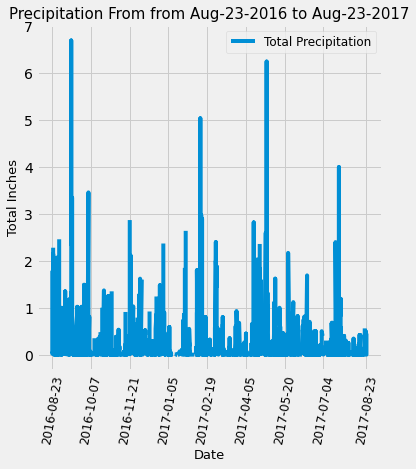

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
start_date = dt.datetime(2016,8,22)
one_year = session.query(Measurement.prcp,Measurement.date).filter(Measurement.date>start_date)

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_df = pd.DataFrame(one_year)
precipitation_df.index = precipitation_df['date']
precipitation_df = pd.DataFrame(precipitation_df['prcp']).sort_values(by = ['date'])

# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 1.2])
ax.plot(precipitation_df.index, precipitation_df, label = 'Total Precipitation')
ax.set_xticks([0,45,90,135,180,225,270,315,365])
plt.xticks(rotation=80, fontsize=12)
plt.title('Precipitation From from Aug-23-2016 to Aug-23-2017', fontsize=15)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Inches', fontsize=13)
plt.legend(loc="upper right", fontsize=12)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).count()
print(f'There are {station_count} total stations available in the dataset')

There are 9 total stations available in the dataset


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = 'USC00519281'
data = session.query(func.min(Measurement.tobs),
             func.max(Measurement.tobs),
             func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()
all = list(np.ravel(data))
print(f"For station {most_active} the min temp was {all[0]}, the max temp was {all[1]}, the avg temp was {all[2]:1.2f} between Aug 23, 2016 and Aug 23,2017.")

For station USC00519281 the min temp was 54.0, the max temp was 85.0, the avg temp was 71.66 between Aug 23, 2016 and Aug 23,2017.


Text(0, 0.5, 'Frequency')

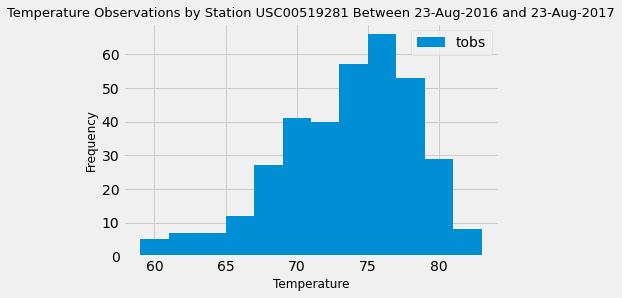

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_obs = active_stations[0][0]

results = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.date >= "2016-08-23").\
                        filter(Measurement.date <= "2017-08-23").\
                        filter(Measurement.station == most_obs).all()

results_df = pd.DataFrame(results)

results_df.plot.hist(bins=12)
plt.title('Temperature Observations by Station USC00519281 Between 23-Aug-2016 and 23-Aug-2017', fontsize=13)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Close session

In [21]:
# Close Session
session.close()